In [26]:
# ==========================================
# CELL 1: SETUP WITH CORRECTED SPLITS (V5)
# ==========================================
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
BATCH_SIZE = 32
NUM_EPOCHS = 40 # Standard epochs are fine now that we have real data
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- EMOTION NAMES ---
EMOTION_NAMES = {
    0: 'Happily surprised', 1: 'Happily disgusted', 2: 'Sadly fearful',
    3: 'Sadly angry', 4: 'Sadly surprised', 5: 'Sadly disgusted',
    6: 'Fearfully angry', 7: 'Fearfully surprised', 8: 'Fearfully disgusted',
    9: 'Angrily surprised', 10: 'Angrily disgusted', 11: 'Disgustedly surprised',
    12: 'Happily fearful', 13: 'Happily sad'
}

# --- HELPER PATH FINDER ---
def find_file(filename, search_path='/kaggle/input'):
    for root, dirs, files in os.walk(search_path):
        if filename in files: return os.path.join(root, filename)
    raise FileNotFoundError(f"❌ Could not find {filename}")

def find_folder(foldername, search_path='/kaggle/input'):
    for root, dirs, files in os.walk(search_path):
        if foldername in dirs: return os.path.join(root, foldername)
    for root, dirs, files in os.walk(search_path):
        if foldername in root: return root
    raise FileNotFoundError(f"❌ Could not find folder {foldername}")

# --- DATA LOADING ---
try:
    print("🕵️ Locating files...")
    PATH_LABEL_TXT = find_file("RAFCE_emolabel.txt")
    PATH_PARTITION = find_file("RAFCE_partition.txt")
    PATH_IMAGES = find_folder("dataset_resnet_224")
    print(f"✅ Images found at: {PATH_IMAGES}")
except Exception as e:
    print("🛑 FATAL ERROR: Missing Files.")
    raise e

# 1. Load & Merge
df_emo = pd.read_csv(PATH_LABEL_TXT, sep=r'\s+', header=None, names=['filename', 'emotion_id'])
df_part = pd.read_csv(PATH_PARTITION, sep=r'\s+', header=None, names=['filename', 'split_id'])
df = pd.merge(df_emo, df_part, on='filename')

# 2. ⚠️ CORRECTED SPLIT LOGIC ⚠️
# Official Docs: 0=Train, 1=Test, 2=Validation
# Strategy: Train on Train(0) + Val(2) to maximize data. Test on Test(1).
print("🔄 Applying Corrected Splits...")

# Train = Split 0 (2709 imgs) + Split 2 (931 imgs) = 3640 Images!
df_train = df[df['split_id'].isin([0, 2])].copy() 

# Test = Split 1 (909 imgs) - Used for Validation Accuracy
df_test = df[df['split_id'] == 1].copy()

print(f"📊 Training Samples: {len(df_train)} (Was ~900, now ~3600!)")
print(f"📊 Validation Samples: {len(df_test)}")

# 3. CALCULATE SAMPLER WEIGHTS (For Balance)
print("⚖️ Calculating Sampler Weights...")
class_counts = df_train['emotion_id'].value_counts().sort_index()
class_weights = 1.0 / class_counts
df_train['weight'] = df_train['emotion_id'].map(class_weights)
samples_weight = torch.from_numpy(df_train['weight'].values).double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# --- DATASET CLASS ---
class RAFCEDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = os.path.join(self.root_dir, fname)
        
        # File finding fallback
        if not os.path.exists(img_path):
             base = fname.split('.')[0]
             if os.path.exists(os.path.join(self.root_dir, base + '.png')):
                 img_path = os.path.join(self.root_dir, base + '.png')
             elif os.path.exists(os.path.join(self.root_dir, base + '.jpg')):
                 img_path = os.path.join(self.root_dir, base + '.jpg')
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            
        if self.transform:
            image = self.transform(image)
            
        label = int(row['emotion_id']) 
        return image, torch.tensor(label, dtype=torch.long)

# --- AUGMENTATION ---
# Strong augmentation for the larger dataset
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = RAFCEDataset(df_train, PATH_IMAGES, transform=transforms_train)
val_set = RAFCEDataset(df_test, PATH_IMAGES, transform=transforms_val)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ Data Pipeline Corrected. Ready for Training.")

🕵️ Locating files...
✅ Images found at: /kaggle/input/raf-ce-processed-ready/dataset_resnet_224
🔄 Applying Corrected Splits...
📊 Training Samples: 3640 (Was ~900, now ~3600!)
📊 Validation Samples: 909
⚖️ Calculating Sampler Weights...
✅ Data Pipeline Corrected. Ready for Training.


In [27]:
print(f"Min Label ID: {df['emotion_id'].min()}")
print(f"Max Label ID: {df['emotion_id'].max()}")
print(f"Unique Labels: {df['emotion_id'].unique()}")

Min Label ID: 0
Max Label ID: 13
Unique Labels: [ 5 10  3  2  0  9  1  7 13 12  4  6 11  8]


👀 Visualizing Trainiiing Batch...


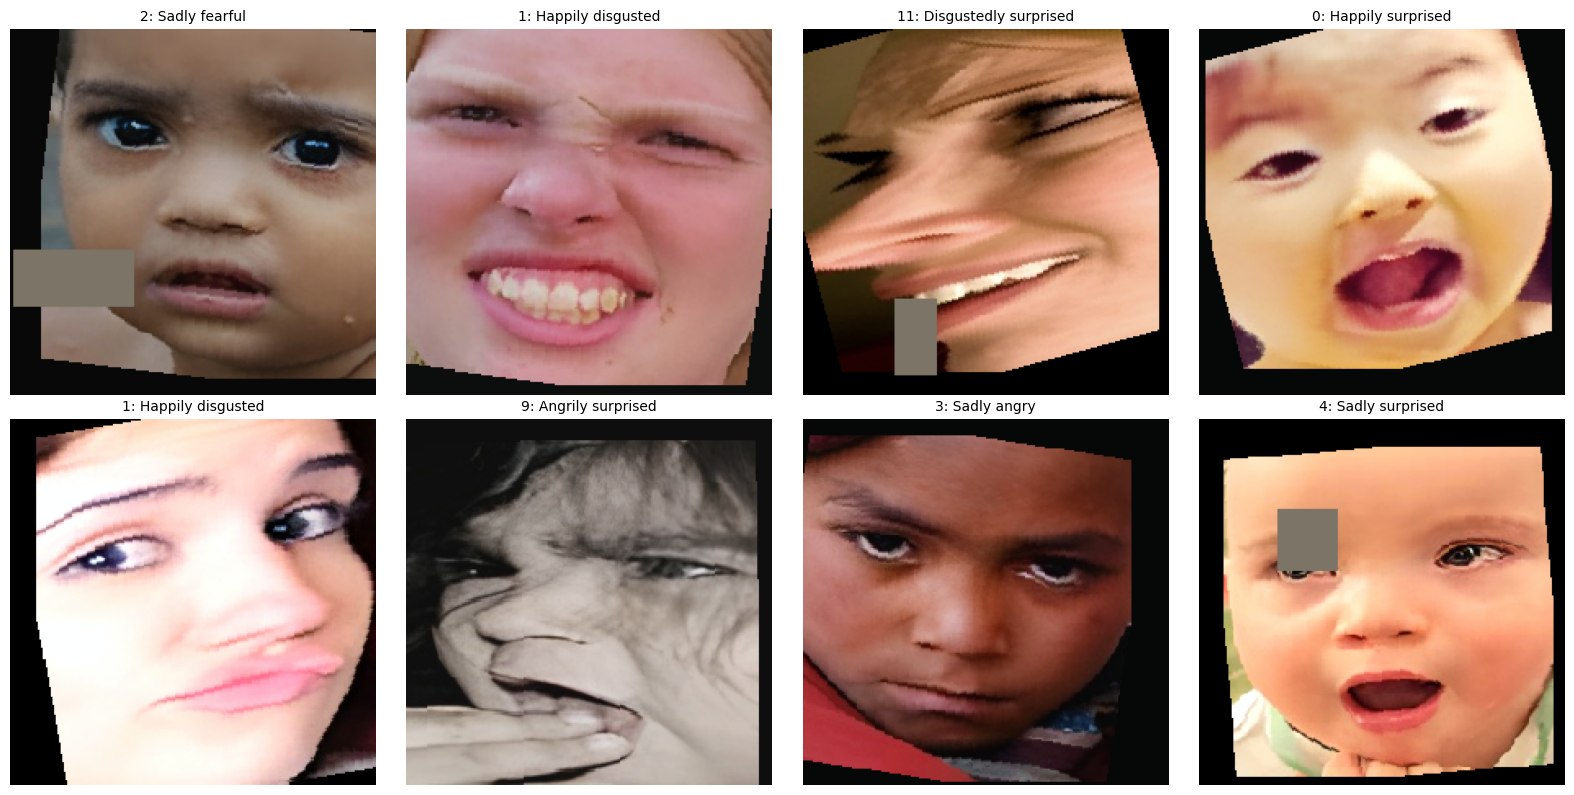

In [28]:
# ==========================================
# CELL 2: VISUAL SANITY CHECK (WITH NAMES)
# ==========================================
def show_batch(loader):
    images, labels = next(iter(loader))
    
    plt.figure(figsize=(16, 8))
    for i in range(min(8, len(images))): 
        ax = plt.subplot(2, 4, i + 1)
        
        # Un-normalize
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Get Name
        lbl_idx = labels[i].item()
        lbl_name = EMOTION_NAMES.get(lbl_idx, "Unknown")
        
        plt.imshow(img)
        plt.title(f"{lbl_idx}: {lbl_name}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("👀 Visualizing Trainiiing Batch...")
show_batch(train_loader)

In [30]:
# ==========================================
# CELL X: DATA DISTRIBUTION CHECK
# ==========================================
print("🕵️ Investigating Split IDs...")

# Count how many images are in each split (0, 1, 2, etc.)
split_counts = df['split_id'].value_counts().sort_index()
print("\n📊 Image Counts per Split ID:")
print(split_counts)

print("\n🔍 Sample Check:")
for split_id in split_counts.index:
    sample_row = df[df['split_id'] == split_id].iloc[0]
    print(f"   Split {split_id}: Example {sample_row['filename']} (Emotion {sample_row['emotion_id']})")

print("\n💡 INTERPRETATION:")
if 0 in split_counts and split_counts[0] > 100:
    print("⚠️ CRITICAL: We found a 'Split 0' with many images!")
    print("   If we are currently ignoring this, adding it to Training will boost accuracy.")
else:
    print("   Split 0 seems negligible or empty.")

🕵️ Investigating Split IDs...

📊 Image Counts per Split ID:
split_id
0    2709
1     909
2     931
Name: count, dtype: int64

🔍 Sample Check:
   Split 0: Example 0001.jpg (Emotion 5)
   Split 1: Example 0003.jpg (Emotion 10)
   Split 2: Example 0002.jpg (Emotion 5)

💡 INTERPRETATION:
⚠️ CRITICAL: We found a 'Split 0' with many images!
   If we are currently ignoring this, adding it to Training will boost accuracy.


In [32]:
# ==========================================
# CELL 3: TRAIN WITH COSINE ANNEALING & SMOOTHING
# ==========================================
import torch.optim as optim

print("🏗️ Initializing ResNet-18 (Pro Setup)...")
model = models.resnet18(weights='IMAGENET1K_V1')

# Head
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Moderate dropout
    nn.Linear(num_ftrs, 14)
)
model = model.to(DEVICE)

# ⚠️ NEW: Label Smoothing (Helps generalization significantly)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4) # Higher starting LR

# ⚠️ NEW: Cosine Annealing Scheduler (The "Wave" approach)
# This resets the LR every 10 epochs to help find new minimums
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

def train_model(num_epochs):
    best_acc = 0.0
    history = {'train_loss': [], 'val_acc': []}
    
    print(f"🚀 Starting Training (Cosine Annealing)...")
    
    for epoch in range(num_epochs):
        model.train()
        run_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            run_loss += loss.item() * images.size(0)
            pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
            
        epoch_loss = run_loss / len(train_set)
        
        # Step the scheduler (Cosine requires stepping at batch or epoch)
        scheduler.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['val_acc'].append(val_acc)
        
        print(f"   Stats: Loss={epoch_loss:.4f} | Val Acc={val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_resnet18.pth")

    print(f"\n🏆 Final Best Accuracy: {best_acc:.2f}%")
    return history

# Train for 30 epochs (3 cycles of cosine)
history = train_model(40)

🏗️ Initializing ResNet-18 (Pro Setup)...
🚀 Starting Training (Cosine Annealing)...


Epoch 1/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=2.2155 | Val Acc=14.85%


Epoch 2/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.8223 | Val Acc=20.90%


Epoch 3/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.6515 | Val Acc=33.44%


Epoch 4/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.4858 | Val Acc=40.70%


Epoch 5/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.3240 | Val Acc=41.69%


Epoch 6/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.2342 | Val Acc=46.97%


Epoch 7/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.0775 | Val Acc=48.62%


Epoch 8/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9973 | Val Acc=49.50%


Epoch 9/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9552 | Val Acc=50.72%


Epoch 10/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8891 | Val Acc=51.49%


Epoch 11/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.3105 | Val Acc=30.03%


Epoch 12/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.2695 | Val Acc=43.01%


Epoch 13/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.1709 | Val Acc=46.64%


Epoch 14/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.0634 | Val Acc=46.09%


Epoch 15/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9724 | Val Acc=49.61%


Epoch 16/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9102 | Val Acc=48.07%


Epoch 17/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8448 | Val Acc=53.47%


Epoch 18/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8046 | Val Acc=52.70%


Epoch 19/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7762 | Val Acc=53.03%


Epoch 20/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7684 | Val Acc=52.81%


Epoch 21/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9804 | Val Acc=47.96%


Epoch 22/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=1.0426 | Val Acc=51.49%


Epoch 23/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9798 | Val Acc=46.86%


Epoch 24/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9244 | Val Acc=44.66%


Epoch 25/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8517 | Val Acc=51.49%


Epoch 26/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8036 | Val Acc=51.49%


Epoch 27/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7569 | Val Acc=52.70%


Epoch 28/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7139 | Val Acc=53.91%


Epoch 29/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7026 | Val Acc=54.02%


Epoch 30/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7041 | Val Acc=53.47%


Epoch 31/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8584 | Val Acc=43.01%


Epoch 32/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9301 | Val Acc=44.55%


Epoch 33/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.9040 | Val Acc=49.50%


Epoch 34/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.8294 | Val Acc=45.10%


Epoch 35/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7808 | Val Acc=51.82%


Epoch 36/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7318 | Val Acc=52.70%


Epoch 37/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.7090 | Val Acc=52.81%


Epoch 38/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.6811 | Val Acc=52.70%


Epoch 39/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.6710 | Val Acc=52.92%


Epoch 40/40:   0%|          | 0/114 [00:00<?, ?it/s]

   Stats: Loss=0.6650 | Val Acc=52.59%

🏆 Final Best Accuracy: 54.02%


🧐 Setting up Official Test Set (Split ID = 1)...
✅ Loaded 909 images for Final Testing.
📈 Loading Best Model Weights...
✅ Model Loaded Successfully.
   Running Predictions...


  0%|          | 0/29 [00:00<?, ?it/s]


🏆 OFFICIAL TEST ACCURACY: 54.02%

                       precision    recall  f1-score   support

    Happily surprised       0.66      0.68      0.67       126
    Happily disgusted       0.42      0.31      0.36        54
        Sadly fearful       0.39      0.31      0.34        36
          Sadly angry       0.29      0.18      0.22        44
      Sadly surprised       0.50      0.16      0.24        25
      Sadly disgusted       0.60      0.59      0.60       178
      Fearfully angry       0.58      0.42      0.49        43
  Fearfully surprised       0.53      0.68      0.60       113
  Fearfully disgusted       0.00      0.00      0.00         6
    Angrily surprised       0.50      0.41      0.45        44
    Angrily disgusted       0.54      0.73      0.62       194
Disgustedly surprised       0.25      0.16      0.20        37
      Happily fearful       0.00      0.00      0.00         1
          Happily sad       0.00      0.00      0.00         8

             accur

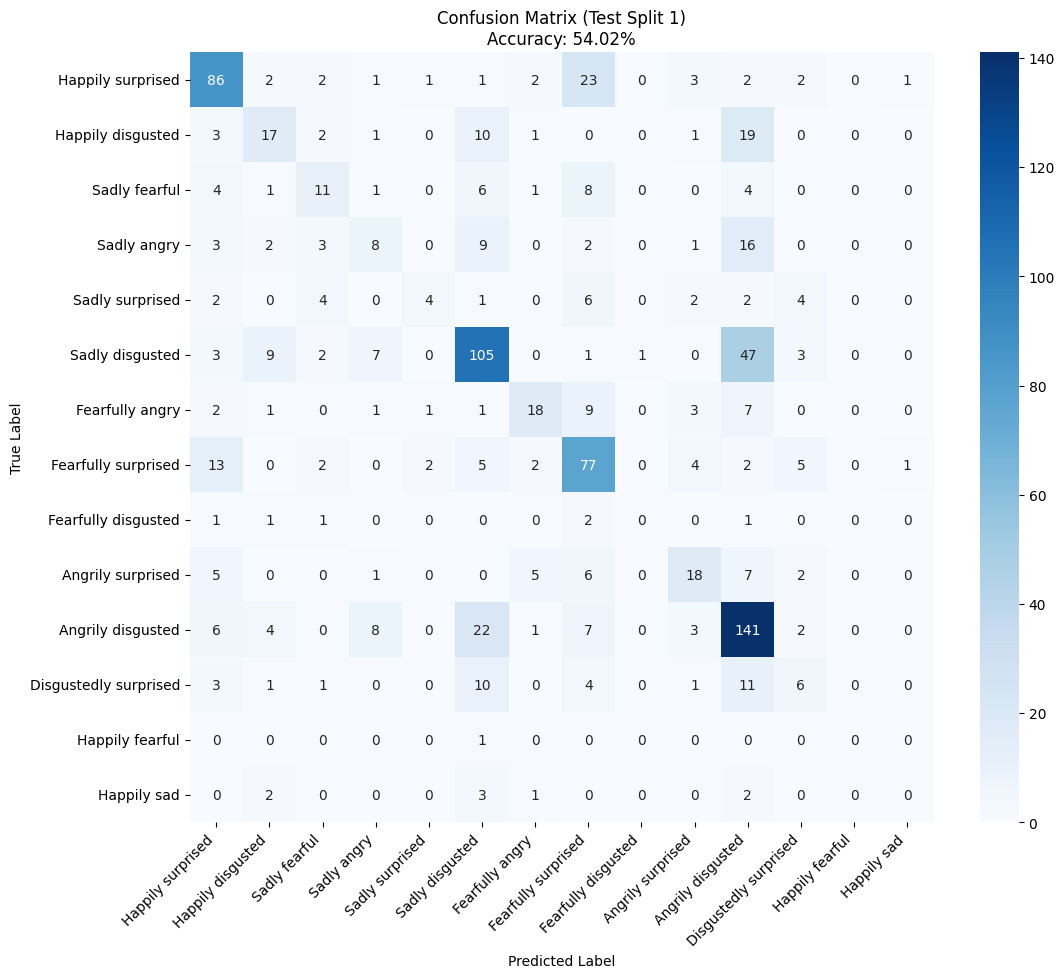

In [36]:
# ==========================================
# CELL 4: FINAL TEST EVALUATION (OFFICIAL)
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. SETUP: Ensure we are using the OFFICIAL TEST SET (Split 1)
print("🧐 Setting up Official Test Set (Split ID = 1)...")
# Re-filter just to be absolutely sure
df_final_test = df[df['split_id'] == 1].copy()
test_set = RAFCEDataset(df_final_test, PATH_IMAGES, transform=transforms_val)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(df_final_test)} images for Final Testing.")

# 2. LOAD MODEL
print("📈 Loading Best Model Weights...")
model = models.resnet18(weights=None) 
num_ftrs = model.fc.in_features
# Must match the architecture from Cell 3 exactly
model.fc = nn.Sequential(
    nn.Dropout(0.3), 
    nn.Linear(num_ftrs, 14)
)
try:
    model.load_state_dict(torch.load("best_resnet18.pth"))
    model = model.to(DEVICE)
    model.eval()
    print("✅ Model Loaded Successfully.")
except Exception as e:
    print(f"❌ Error: {e}")
    print("   (Did you restart the session? You need 'best_resnet18.pth' in your files)")

# 3. EVALUATE
all_preds = []
all_labels = []

print("   Running Predictions...")
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. RESULTS
final_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print("\n" + "="*40)
print(f"🏆 OFFICIAL TEST ACCURACY: {final_acc:.2f}%")
print("="*40 + "\n")

# 5. DETAILED REPORT
target_names = [EMOTION_NAMES[i] for i in range(14)]
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

# 6. CONFUSION MATRIX
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
# Normalize matrix to show percentages (easier to see where errors are)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix (Test Split 1)\nAccuracy: {final_acc:.2f}%')
plt.xticks(rotation=45, ha='right')
plt.show()